### Clone repo to access GPT2 weights

In [35]:
! git clone https://github.com/muxitox/nanoGPT.git

fatal: destination path 'nanoGPT' already exists and is not an empty directory.


In [36]:
%cd nanoGPT

/home/apoc/Documents/projects/nanoGPT/simple_model/nanoGPT/nanoGPT


/home/apoc/Documents/projects/nanoGPT/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


### Imports

In [37]:
import math
import inspect
from dataclasses import dataclass

import torch
import torch.nn as nn
from torch.nn import functional as F
from model import GPTConfig, GPT

import matplotlib.pyplot as plt
import time

In [38]:
!pip install ipdb
import ipdb


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


### Utils

In [39]:
def bitfield(n, size):  # Transform positive integer into bit array
    x = [int(x) for x in bin(int(n))[2:]]
    x = [0] * (size - len(x)) + x
    return torch.array(x)

#### Plotting

In [40]:
def return_subplot(num_feats):
    if num_feats == 1:
        fig, ax = plt.subplots(1, 1)
    elif num_feats == 2:
        fig, ax = plt.subplots(2, 1)
    elif num_feats == 3:
        fig, ax = plt.subplots(3, 1)
    else:
        fig, ax = plt.subplots(min(4, math.floor((num_feats)/2)), 2)

    return fig, ax

In [41]:
def subplot_trajectories(stats, label, line, title, domain_label, random_feats=False, max_feats_show=4):

    T, num_feats = stats[0].shape
    num_feats_show = min(num_feats, max_feats_show)

    fig, ax = return_subplot(num_feats_show)
    ax = ax.ravel()

    if max_feats_show > 4 and random_feats:
        feats = torch.randperm(stats[0].shape[1])[:num_feats_show]
    else:
        feats = torch.arange(num_feats_show)

    for i in range(0, num_feats_show):
        for s in range(len(stats)):
            ax[i].plot(stats[s][:,feats[i]], line[s], label=label[s])

            ax[i].set_ylabel(f"${domain_label}_{{{feats[i]}}}$")
            ax[i].set_xlabel(f"$t$")

        if i==num_feats_show - 1:
            ax[i].legend()
    plt.suptitle(title)

### Forward functions for the network

In [42]:
def forward(tok_emb_t_1, x_t, W_k, W_q, beta=1.0):
    # apply softmax to get probabilities
    k_t_1 = tok_emb_t_1 @ W_k.T
    q_t = x_t @ W_q.T
    Wk_Wq_x_t = W_k.T @ q_t  # Compute this also for comparison

    probs = F.softmax(beta * k_t_1 @ q_t, dim=0)

    # sample from the distribution
    idx_next = torch.multinomial(probs, num_samples=1)

    tok_t = tok_emb_t_1[idx_next][0]

    return tok_t, idx_next, Wk_Wq_x_t, q_t, probs

In [43]:
def forward_mf(mu, cov, tok_emb, W_k, W_q, beta):

    # Compute the probability of the text token
    k = tok_emb @ W_k.T
    p_k = beta * k @ mu + beta**2 * torch.einsum('ni,ij,nj->n', k, cov, k) / 2

    p_k = F.softmax(p_k, dim=0)

    max_k_idx = torch.argmax(p_k, dim=0)

    # Get the mean of x
    mu_x = torch.sum(p_k[:, None] * tok_emb, dim=0)

    mu_k = mu_x @ W_k.T
    mu_q = mu_x @ W_q.T

    q = tok_emb @ W_q.T
    q_centered = q - mu_q
    sigma_q = torch.einsum('n,nm,nk->mk', p_k, q_centered, q_centered)

    return mu_k, mu_q, sigma_q, max_k_idx, p_k

### Experiment settings

In [44]:
num_trials = 20000
num_running_steps = 5

timesteps_to_examine = [0, 1, 2, 3, 4] # For debugging purposes

### Network settings

In [45]:
beta = 1.3
binary_vars = False
q_is_roll = False  # If W_q a shift over W_k
patterns_from_vocab = True # If you draw samples from the token vocab to make the W patterns
emb_size = 500 # Number of tokens in the embedding. -1 if you want the full vocab size
num_patterns = 3  # Number of patterns in the W matrices. -1 if you want to match token_size
token_size = 250 # Number of features. If -1, match with the embedding token size, otherwise, force your selection.
random_ini_token = True
ini_token_idx = 0
# prev seed  150
seed = 158

torch.manual_seed(seed)


In [46]:
device = 'cpu'  # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.

if not binary_vars:

    # In this case instead of initializing from random varialbes, use GPT2 embeddings
    # as initialization (They are distributed in a Gaussian way for a large number of tokens).

    # Load GPT2
    model_name = "gpt2"
    model = GPT.from_pretrained(model_name, dict(dropout=0.0))
    model.to(device)

loading weights from pretrained gpt: gpt2
forcing vocab_size=50257, block_size=1024, bias=True
overriding dropout rate to 0.0
number of parameters: 123.65M


In [47]:
####################
# Set up the vocabulary and weights
####################

# Define the tokens or spins
if binary_vars:    # Binary variables

    if token_size == -1:
        raise Exception("token_size must be defined")
    if num_patterns == -1:
        raise Exception("num_patterns must be defined")
    if emb_size == -1:
        raise Exception("emb_size must be defined")

    tok_emb = (torch.rand((emb_size, token_size), device=device) > 0.5).float()
    tok_emb = tok_emb * 2 - 1
else:   # Tokens from GPT2

    # Get embeddings to sample tokens from them
    wte = model.transformer.wte
    num_embeddings = wte.num_embeddings

    if token_size==-1:
        token_size = wte.embedding_dim

    if emb_size == -1:
      emb_size = num_embeddings

    if num_patterns == -1:
      num_patterns = token_size

    # Select emb_size tokens from the embedding to create a smaller vocabulary
    perm_tokens_idxs = torch.randperm(num_embeddings)
    tokens_idxs = perm_tokens_idxs[:emb_size]

    # Transform into token representation
    # Equivalent to x_{t+1} in the LaTeX doc
    tok_emb = model.transformer.wte(tokens_idxs).detach()
    perm_feats_idxs = torch.randperm(wte.embedding_dim)
    tok_emb = tok_emb[:, perm_feats_idxs[:token_size]]

# Define the W patterns

if patterns_from_vocab:

    if num_patterns > emb_size:
        raise Exception("num_patterns > emb_size")

    k_patts = torch.randperm(emb_size)[:num_patterns]
    q_patts = torch.randperm(emb_size)[:num_patterns]

    W_k = tok_emb[k_patts]
    W_q = tok_emb[q_patts]

    if binary_vars:
        W_k = W_k / math.sqrt(token_size)
        W_q = W_q / math.sqrt(token_size)
    else:

        tok_mean = torch.mean(tok_emb, dim=None)
        tok_mean_b = torch.mean(tok_emb, dim=0)
        k_mean = torch.mean(tok_emb[k_patts], dim=None)
        q_mean = torch.mean(tok_emb[q_patts], dim=None)
        k_std = torch.std(tok_emb[k_patts], dim=None)
        q_std = torch.std(tok_emb[q_patts], dim=None)

        tok_emb_std = torch.std(tok_emb, dim=None)
        tok_emb_std_b = torch.std(tok_emb, dim=0)

        scaling = torch.sqrt(tok_emb_std_b**2 + tok_mean_b**2)
        # FPC = 1 - (num_patterns / emb_size)
        # W_k = tok_emb[k_patts] / scaling
        # W_q = tok_emb[q_patts] / scaling
        #
        # J = (1 / math.sqrt(token_size * num_patterns)) * (W_k.T @ W_q)

        W_k = W_k / (scaling * (token_size * num_patterns)**(1/4))
        W_q = W_q / (scaling * (token_size * num_patterns)**(1/4))


    J = (W_k.T @ W_q)
    J_var = torch.var(J, dim=None)
    print("J variance", J_var, 1/token_size)
    print()

else:
    # Create random W patterns
    w_mean = 0
    # w_std = 1/math.sqrt(token_size)
    w_std = 1
    # num_patterns = token_size
    W_k = torch.normal(w_mean, w_std, (num_patterns, token_size))
    W_q = torch.normal(w_mean, w_std, (num_patterns, token_size))

    if binary_vars and not patterns_from_vocab:
        raise Exception("Behavior not programmed yet")

if q_is_roll:
    W_q = torch.roll(W_k, 1, 0)


J variance tensor(0.0046) 0.004



### Choose initial token

In [48]:
# Choose initial token
# Choose x_0
if random_ini_token:
    tok_0 = torch.randn((emb_size, token_size))[ini_token_idx]
else:
    # tok_0 = tok_emb[ini_token_idx]
    tok_0 = W_q[ini_token_idx]


### For debugging purposes

In [49]:
timesteps_to_examine = [t for t in timesteps_to_examine if t < num_running_steps]
timesteps_to_examine_dict = dict([(k,v) for k, v in zip(timesteps_to_examine, range(len(timesteps_to_examine)))])



## Model without approximation

In [50]:
# Variables to save statistics
tok_stats_sim = torch.zeros((num_trials, num_running_steps, token_size))
idxs = torch.zeros((num_trials, num_running_steps))

# Create structure to save data from different runs
n_trials_to_examine = [1, 3]
n_trials_to_examine = [r for r in n_trials_to_examine if r < num_running_steps]
n_trials_to_examine_dict = dict([(k,v) for k, v in zip(n_trials_to_examine, range(len(n_trials_to_examine)))])

probs_sim_t_run = torch.zeros((len(n_trials_to_examine), len(timesteps_to_examine), emb_size))
probs_sim_t_mean = torch.zeros((len(timesteps_to_examine), emb_size))

In [51]:
################################################
# Compute the average over multiple trajectories (without approximation)
################################################

startt = time.time()
for r in range(num_trials):

    if r % 100 == 0:
        print(f"Trial {r+1}/{num_trials}")

    tok_t_1 = tok_0.clone()
    for t in range(num_running_steps):

        # Get the next token
        tok_t_1, idx_t_1, Wk_Wq_x_t, q_t, probs = forward(tok_emb, tok_t_1, W_k, W_q, beta)

        # Accumulate stats
        tok_stats_sim[r, t, :] += tok_t_1
        idxs[r, t] = idx_t_1
        if r in n_trials_to_examine and t in timesteps_to_examine:
            probs_sim_t_run[n_trials_to_examine_dict[r], timesteps_to_examine_dict[t]] = probs
        if t in timesteps_to_examine:
            probs_sim_t_mean[timesteps_to_examine_dict[t], :] = probs_sim_t_mean[timesteps_to_examine_dict[t], :] + probs

probs_sim_t_mean /= num_trials

endt = time.time()
time_elapsed = endt - startt
print(f"Time elapsed: {time_elapsed:.2f} seconds")

print("Selected tokens at each step")
print(idxs[0])
print(idxs[3])
print(idxs[100])
print(idxs[-1])

mode_idxs = torch.mode(idxs, 0).values


tok_stats_sim_avg = torch.mean(tok_stats_sim, dim=0)

Trial 1/20000
Trial 101/20000
Trial 201/20000
Trial 301/20000
Trial 401/20000
Trial 501/20000
Trial 601/20000
Trial 701/20000
Trial 801/20000
Trial 901/20000
Trial 1001/20000
Trial 1101/20000
Trial 1201/20000
Trial 1301/20000
Trial 1401/20000
Trial 1501/20000
Trial 1601/20000
Trial 1701/20000
Trial 1801/20000
Trial 1901/20000
Trial 2001/20000
Trial 2101/20000
Trial 2201/20000
Trial 2301/20000
Trial 2401/20000
Trial 2501/20000
Trial 2601/20000
Trial 2701/20000
Trial 2801/20000
Trial 2901/20000
Trial 3001/20000
Trial 3101/20000
Trial 3201/20000
Trial 3301/20000
Trial 3401/20000
Trial 3501/20000
Trial 3601/20000
Trial 3701/20000
Trial 3801/20000
Trial 3901/20000
Trial 4001/20000
Trial 4101/20000
Trial 4201/20000
Trial 4301/20000
Trial 4401/20000
Trial 4501/20000
Trial 4601/20000
Trial 4701/20000
Trial 4801/20000
Trial 4901/20000
Trial 5001/20000
Trial 5101/20000
Trial 5201/20000
Trial 5301/20000
Trial 5401/20000
Trial 5501/20000
Trial 5601/20000
Trial 5701/20000
Trial 5801/20000
Trial 590

In [52]:
idxs[0]

tensor([ 57., 248.,  57.,  81., 462.])

In [53]:
probs_sim_t_run[0, 0, :] == probs_sim_t_run[1, 0, :]

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, Tr

## Model with approximation

In [54]:
# Variables to save stats
mu_q_t_1 = tok_0 @ W_q.T
cov_q_t_1 = torch.zeros((num_patterns, num_patterns))

stats_k_mf = torch.zeros((num_running_steps, num_patterns))
idxs_mf = torch.zeros(num_running_steps)

probs_mf_t = torch.zeros(len(timesteps_to_examine), emb_size)
q_mf_t = torch.zeros(len(timesteps_to_examine), num_patterns)
q_mf_cov_t = torch.zeros(len(timesteps_to_examine), num_patterns, num_patterns)



In [55]:
#####
# Compute the approximation
########


for t in range(num_running_steps):

    mu_k, mu_q_t_1, cov_q_t_1, max_k, probs_mf = forward_mf(mu_q_t_1, cov_q_t_1, tok_emb, W_k, W_q, beta)

    # Save stats
    idxs_mf[t] = max_k
    stats_k_mf[t] = mu_k
    if t in timesteps_to_examine:
        probs_mf_t[timesteps_to_examine_dict[t]] = probs_mf
        q_mf_t[timesteps_to_examine_dict[t]] = mu_q_t_1
        q_mf_cov_t[timesteps_to_examine_dict[t]] = cov_q_t_1



In [56]:
q_mf_t[0]

tensor([0.3994, 0.2599, 0.5574])

In [57]:
q_mf_cov_t[0]

tensor([[4.0965e-06, 1.4875e-06, 1.4635e-06],
        [1.4875e-06, 8.7292e-07, 6.2920e-07],
        [1.4635e-06, 6.2920e-07, 7.1291e-07]])

### Model with approximation (mean and covariances estimated from prev time-step)

In [58]:
# Variables to save stats
mu_q_t_1_m3 = tok_0 @ W_q.T
cov_q_t_1_m3 = torch.zeros((num_patterns, num_patterns))

stats_k_mf_m3 = torch.zeros((num_running_steps, num_patterns))
idxs_mf_m3 = torch.zeros(num_running_steps)

probs_mf_t_m3 = torch.zeros(len(timesteps_to_examine), emb_size)
q_mf_t_m3 = torch.zeros(len(timesteps_to_examine), num_patterns)
q_mf_cov_t_m3 = torch.zeros(len(timesteps_to_examine), num_patterns, num_patterns)

In [65]:
#####
# Compute the approximation
########


for t in range(num_running_steps):

    mu_k, mu_q_t_1_m3, cov_q_t_1_m3, max_k, probs_mf = forward_mf(mu_q_t_1_m3, cov_q_t_1_m3, tok_emb, W_k, W_q, beta)

    # Save stats
    idxs_mf_m3[t] = max_k
    stats_k_mf_m3[t] = mu_k
    if t in timesteps_to_examine:
        probs_mf_t_m3[timesteps_to_examine_dict[t]] = probs_mf
        q_mf_t_m3[timesteps_to_examine_dict[t]] = mu_q_t_1_m3
        q_mf_cov_t_m3[timesteps_to_examine_dict[t]] = cov_q_t_1_m3

    # Set the mu and sigma for the next step as the average moments of the simulated trajectory
    q_t_1 = tok_stats_sim[:,t,:] @ W_q.T
    mu_q_t_1_m3 = torch.mean(q_t_1, dim=0)
    cov_q_t_1_m3 = torch.cov(q_t_1.T)


## Plotting

True
tensor(1.0000) tensor(1.0000) tensor(1.0000)
False
tensor(0.0938) tensor(0.0938) tensor(0.0938)
False
tensor(0.9272) tensor(0.4908) tensor(0.9272)
False
tensor(0.8503) tensor(0.8325) tensor(0.8503)
False
tensor(0.8802) tensor(0.8704) tensor(0.8802)


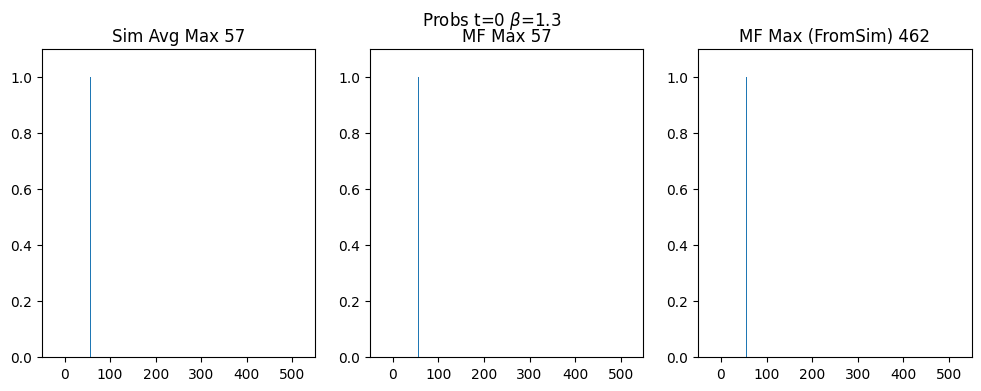

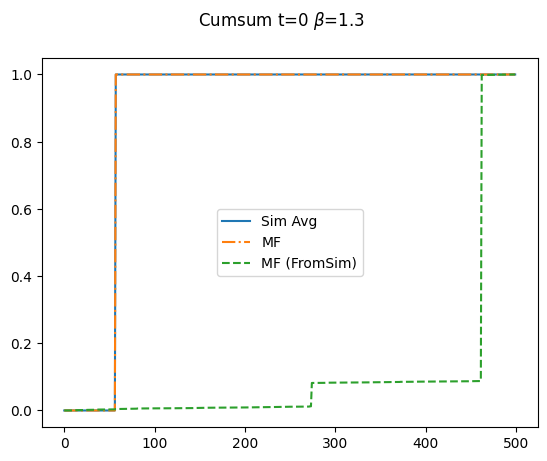

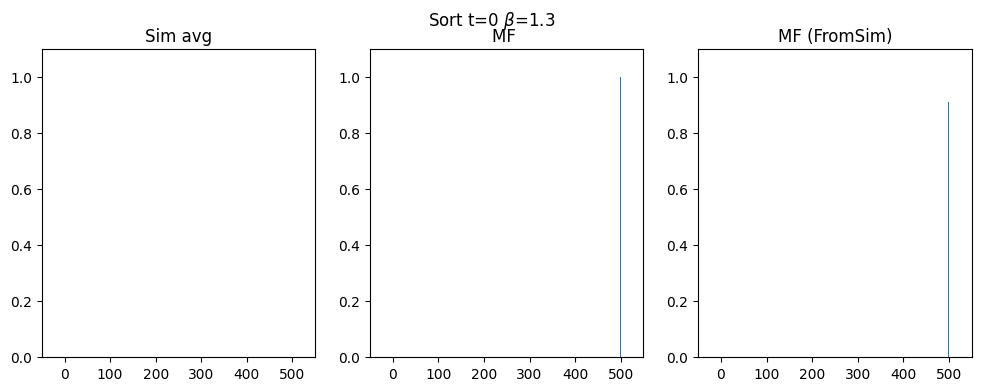

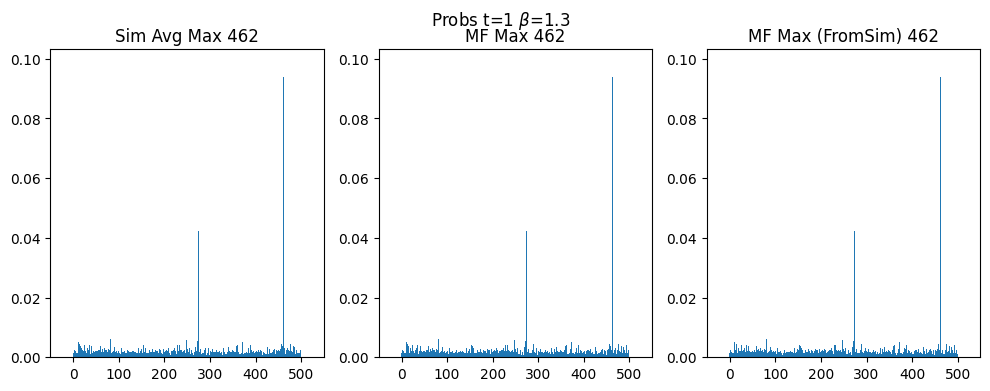

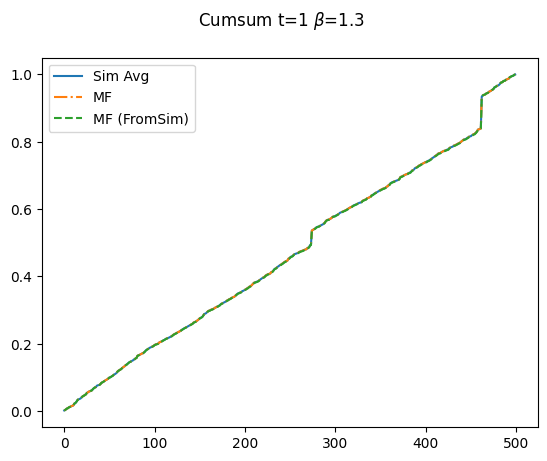

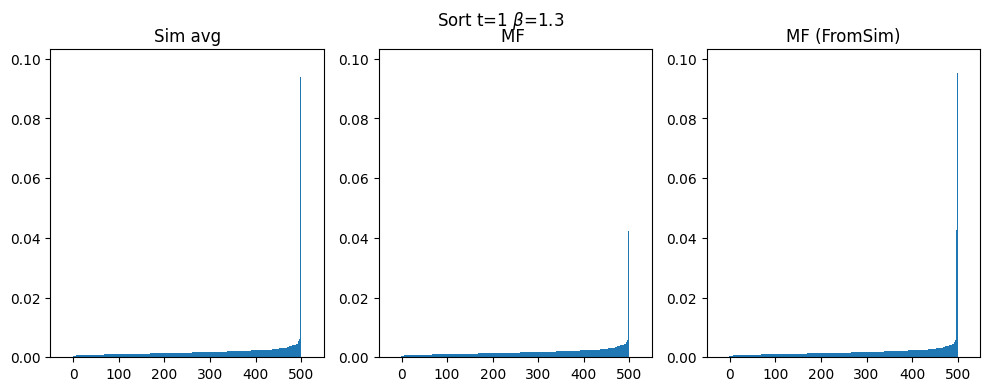

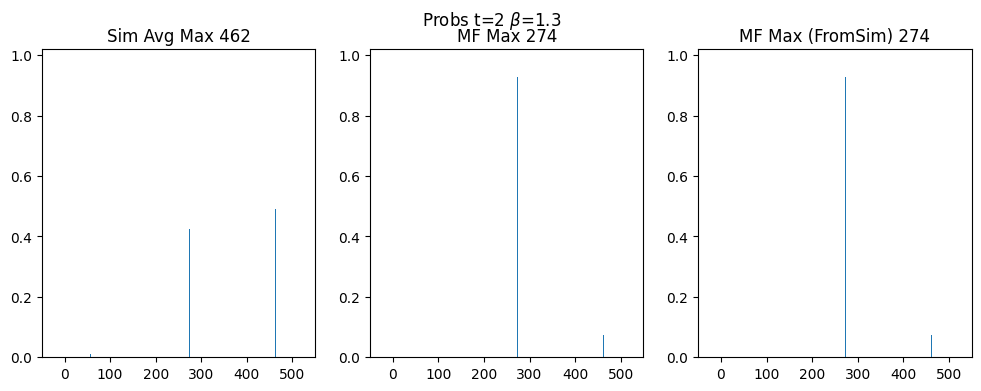

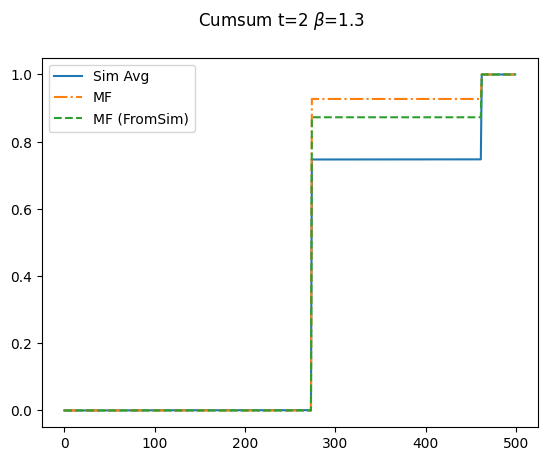

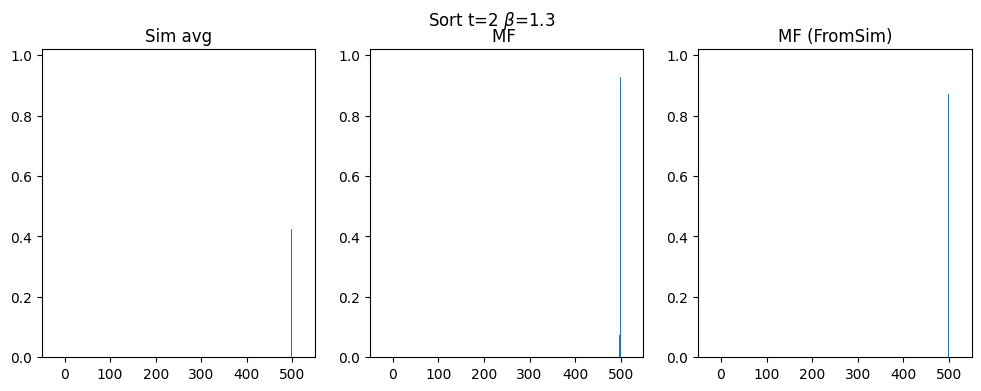

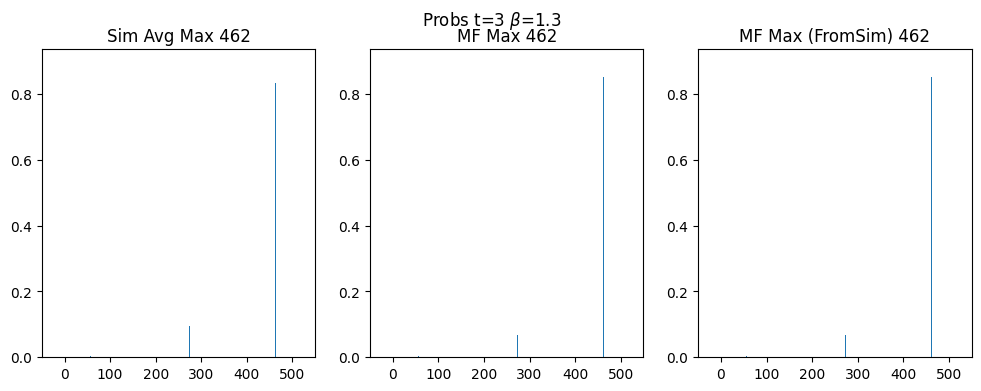

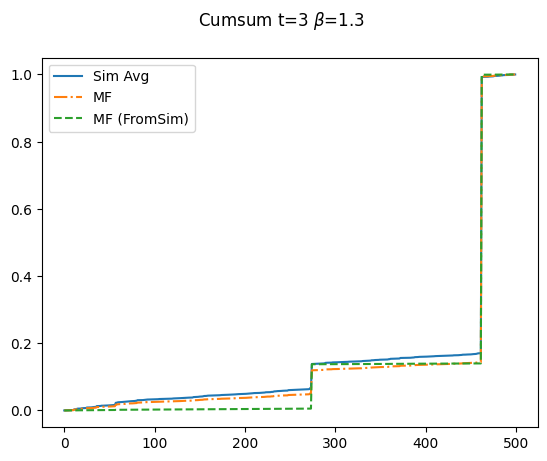

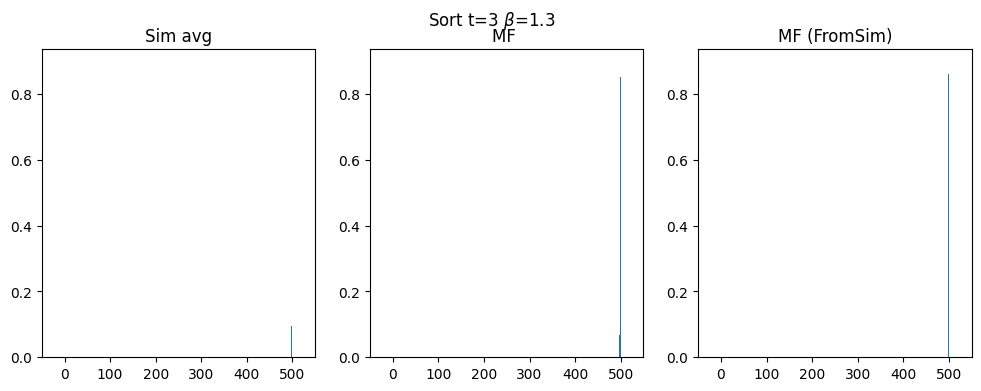

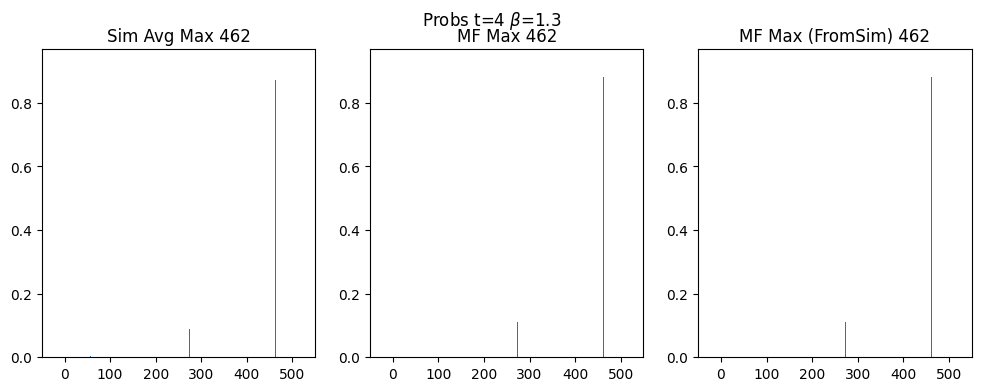

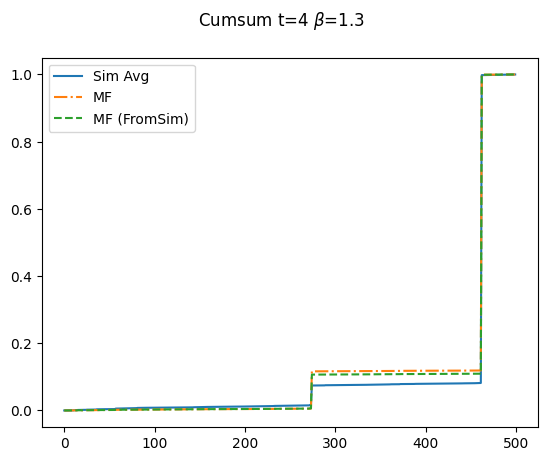

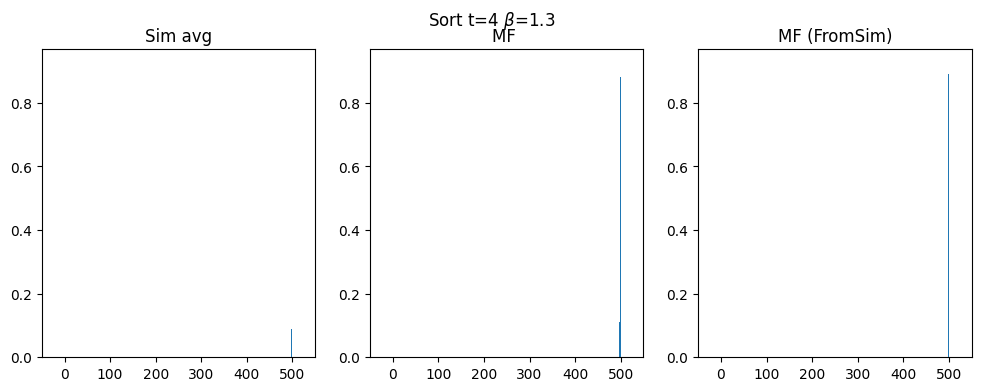

In [66]:
for t in range(len(timesteps_to_examine)):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    print(torch.allclose(probs_sim_t_mean[t, :], probs_mf_t[t, :]))

    maxprob = torch.max(torch.cat((probs_sim_t_mean[t, :], probs_mf_t[t, :])))

    print(maxprob, torch.max(probs_sim_t_mean[t, :]), torch.max(probs_mf_t[t, :]))

    hmargin = 0.1
    vmargin = 0.1
    bw = 2.1

    ax[0].bar(torch.arange(emb_size).int(), probs_sim_t_mean[t, :], width=bw)
    ax[0].set_title(f"Sim Avg Max {torch.argmax(probs_sim_t_mean[t, :])}")
    ax[1].bar(torch.arange(emb_size).int(), probs_mf_t[t, :], width=bw)
    ax[1].set_title(f"MF Max {torch.argmax(probs_mf_t[t, :])}")
    ax[2].bar(torch.arange(emb_size).int(), probs_mf_t[t, :], width=bw)
    ax[2].set_title(f"MF Max (FromSim) {torch.argmax(probs_mf_t_m3[t, :])}")

    for fi in range(3):
        ax[fi].set_ylim(0, maxprob + maxprob * vmargin)
        ax[fi].set_xlim(0 - emb_size * hmargin, emb_size + emb_size * hmargin)
    plt.suptitle(rf"Probs t={timesteps_to_examine[t]} $\beta$={beta}")

    plt.figure()
    plt.plot(torch.arange(emb_size), torch.cumsum(probs_sim_t_run[0, t, :], dim=0), label="Sim Avg")
    plt.plot(torch.arange(emb_size), torch.cumsum(probs_mf_t[t, :], dim=0), "-.", label="MF")
    plt.plot(torch.arange(emb_size), torch.cumsum(probs_mf_t_m3[t, :], dim=0), "--", label="MF (FromSim)")
    plt.suptitle(rf"Cumsum t={timesteps_to_examine[t]} $\beta$={beta}")
    plt.legend()

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].bar(torch.arange(emb_size), torch.sort(probs_sim_t_mean[t, :], dim=0).values, width=bw)
    ax[0].set_title(f"Sim avg")
    ax[1].bar(torch.arange(emb_size), torch.sort(probs_mf_t[t, :], dim=0).values, width=bw)
    ax[1].set_title(f"MF ")
    ax[2].bar(torch.arange(emb_size), torch.sort(probs_mf_t_m3[t, :], dim=0).values, width=bw)
    ax[2].set_title(f"MF (FromSim)")


    for fi in range(3):
        ax[fi].set_ylim(0, maxprob + maxprob * vmargin)
        ax[fi].set_xlim(0 - emb_size * hmargin, emb_size + emb_size * hmargin)

    plt.suptitle(rf"Sort t={timesteps_to_examine[t]} $\beta$={beta}")



In [67]:
 t_explore = 3
 print(torch.sum(torch.sort(probs_sim_t_run[0, t_explore, :], dim=0).values))
 print(torch.sort(probs_sim_t_run[0, t_explore, :], dim=0).values)

tensor(1.0000)
tensor([4.2949e-06, 5.5213e-06, 7.5840e-06, 7.5947e-06, 8.4100e-06, 8.5898e-06,
        8.7329e-06, 9.3459e-06, 1.0598e-05, 1.1824e-05, 1.1971e-05, 1.2012e-05,
        1.2329e-05, 1.2380e-05, 1.2875e-05, 1.3029e-05, 1.3372e-05, 1.3640e-05,
        1.3824e-05, 1.3880e-05, 1.4088e-05, 1.4535e-05, 1.5006e-05, 1.5085e-05,
        1.5258e-05, 1.5350e-05, 1.5833e-05, 1.5849e-05, 1.6215e-05, 1.7162e-05,
        1.7370e-05, 1.7528e-05, 1.7901e-05, 1.8091e-05, 1.8212e-05, 1.8386e-05,
        1.8853e-05, 1.9026e-05, 1.9574e-05, 1.9699e-05, 2.0916e-05, 2.0997e-05,
        2.1089e-05, 2.1098e-05, 2.1136e-05, 2.1197e-05, 2.1347e-05, 2.1578e-05,
        2.1731e-05, 2.2304e-05, 2.2733e-05, 2.2830e-05, 2.3043e-05, 2.3797e-05,
        2.3868e-05, 2.4523e-05, 2.4955e-05, 2.5025e-05, 2.5820e-05, 2.6419e-05,
        2.6449e-05, 2.6742e-05, 2.6791e-05, 2.7429e-05, 2.7639e-05, 2.7715e-05,
        2.7806e-05, 2.8267e-05, 2.8323e-05, 2.8403e-05, 2.8678e-05, 2.8892e-05,
        2.9151e-05, 2.928

Plot just the average of the simulated trajectory

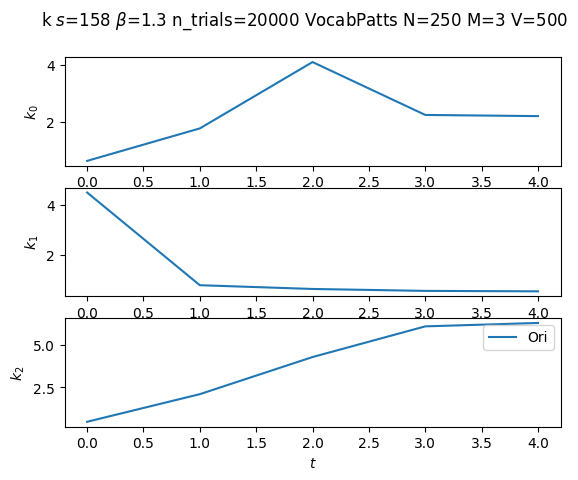

In [68]:
tag = "k"
if patterns_from_vocab:
    patterns_str = "VocabPatts"
else:
    patterns_str = "GaussianPatts"

stats = [tok_stats_sim_avg @ W_k.T]
# stats = [stat[num_patterns:num_patterns*3] for stat in stats]
label = ["Ori"]
line = ["-"]
title = rf"{tag} $s$={seed} $\beta$={beta} n_trials={num_trials} {patterns_str} N={token_size} M={num_patterns} V={emb_size}"
subplot_trajectories(stats, label, line, title, "k", random_feats=False, max_feats_show=3)

Now compare with MF

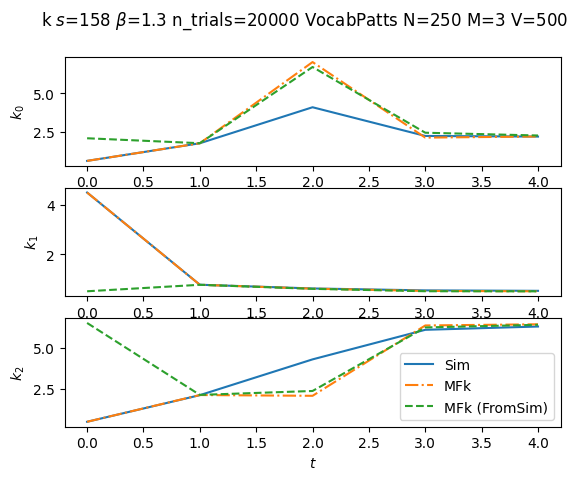

In [69]:
stats = [tok_stats_sim_avg @ W_k.T,  stats_k_mf, stats_k_mf_m3]
label = ["Sim", "MFk", "MFk (FromSim)"]
line = ["-", "-.", "--"]
subplot_trajectories(stats, label, line, title, "k", random_feats=True)

Show the marginal distribution for the Gaussians of $q_t$ for the simulated and approximated model

t 0
q sim tensor([0.3996, 0.2601, 0.5576])
q mf tensor([0.3994, 0.2599, 0.5574])
q sim cov tensor([[0.0002, 0.0002, 0.0003],
        [0.0002, 0.0002, 0.0003],
        [0.0003, 0.0003, 0.0004]])
q mf cov tensor([[4.0965e-06, 1.4875e-06, 1.4635e-06],
        [1.4875e-06, 8.7292e-07, 6.2920e-07],
        [1.4635e-06, 6.2920e-07, 7.1291e-07]])

t 1
q sim tensor([1.2382, 1.2218, 1.4149])
q mf tensor([1.2350, 1.2220, 1.4141])
q sim cov tensor([[0.2545, 0.0327, 0.0687],
        [0.0327, 0.2347, 0.0257],
        [0.0687, 0.0257, 0.2411]])
q mf cov tensor([[0.2565, 0.0313, 0.0677],
        [0.0313, 0.2420, 0.0260],
        [0.0677, 0.0260, 0.2266]])

t 2
q sim tensor([0.9231, 1.3659, 1.3870])
q mf tensor([0.8157, 1.3354, 1.2797])
q sim cov tensor([[0.0439, 0.0100, 0.0226],
        [0.0100, 0.0368, 0.0196],
        [0.0226, 0.0196, 0.0376]])
q mf cov tensor([[0.0021, 0.0014, 0.0028],
        [0.0014, 0.0010, 0.0020],
        [0.0028, 0.0020, 0.0039]])

t 3
q sim tensor([0.9863, 1.4165, 1.4756])


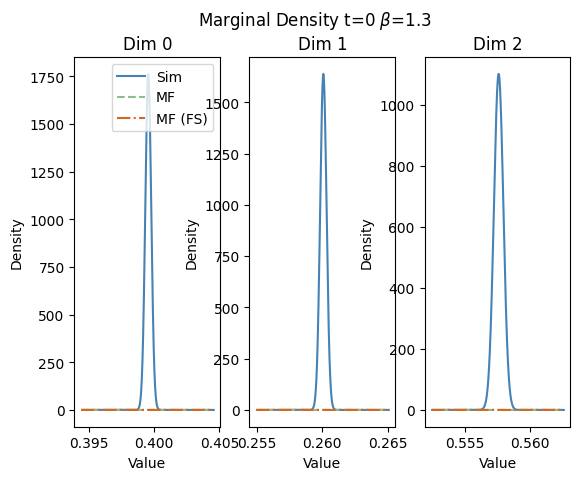

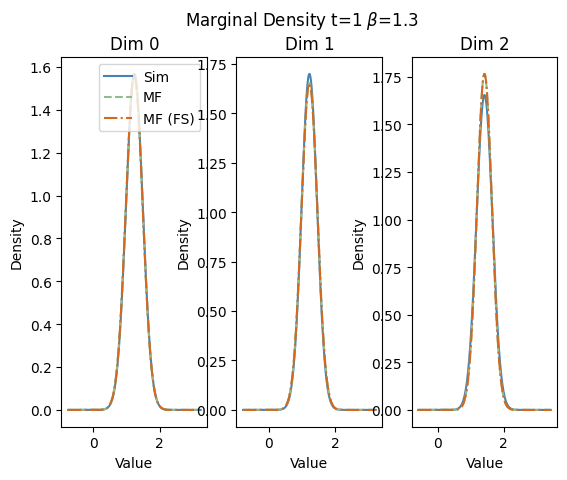

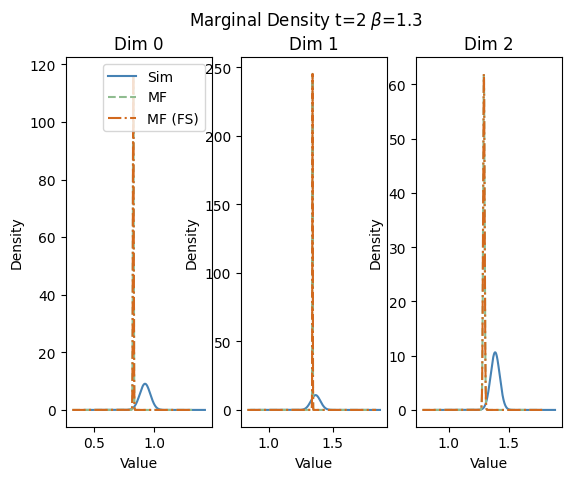

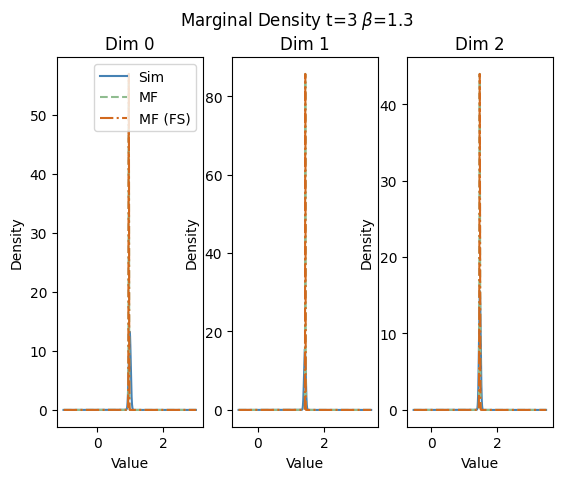

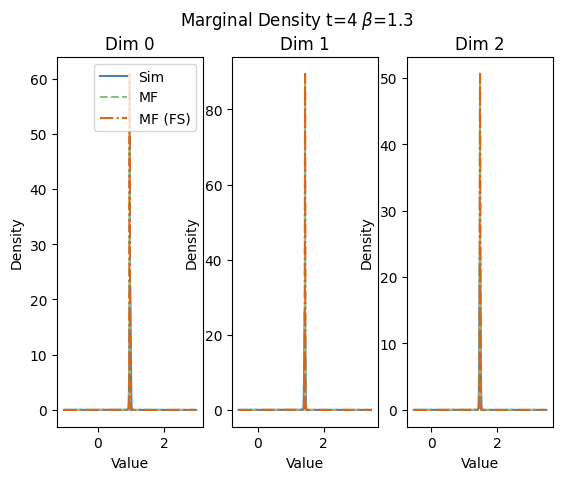

In [70]:
for t in timesteps_to_examine:
    # mean and cov for the simulated model
    q_t = tok_stats_sim[:,t,:] @ W_q.T
    q_sim_mean_t = torch.mean(q_t, dim=0)
    q_sim_cov_t = torch.cov(q_t.T)

    # Add small perturbation to the covariance matrix to force it being positive definite
    diag = torch.diag(torch.ones(num_patterns, num_patterns), diagonal=0) * 10**(-5)
    q_sim_cov_t += diag


    print("t", t)
    print("q sim", q_sim_mean_t)
    print("q mf", q_mf_t[t])
    print("q sim cov", q_sim_cov_t)
    print("q mf cov", q_mf_cov_t[t])

    # Grid config
    num_elems_grid = 2000
    if t == 0:
        grid_width = 0.005
    elif t == 2:
        grid_width = 0.5
    else:
        grid_width = 2
    grid = torch.linspace(-grid_width, grid_width, num_elems_grid)  # adjust range if mean is far from 0


    # Plot
    fig, axes = plt.subplots(1, 3)

    for i in range(3):

        dist_sim = torch.distributions.Normal(loc=q_sim_mean_t[i], scale=q_sim_cov_t[i,i])

        # Distribution for the approximated model
        dist_mf = torch.distributions.Normal(loc=q_mf_t[t,i], scale=q_mf_cov_t[t,i,i])

        dist_mf = torch.distributions.Normal(loc=q_mf_t_m3[t,i], scale=q_mf_cov_t_m3[t,i,i])



        # Simulated model
        # Prepare input: all means, but vary the selected dimension
        x_sim = q_sim_mean_t[i] + grid #  vary selected dimension, center on mean

        logp_sim = dist_sim.log_prob(x_sim)
        p_sim = torch.exp(logp_sim).numpy()

        # Approximated model
        # Prepare input: all means, but vary the selected dimension
        x_mf = q_mf_t[t,i] + grid  # vary selected dimension, center on mean

        logp_mf = dist_mf.log_prob(x_mf)
        p_mf = torch.exp(logp_mf).numpy()

        x_mf_m3 = q_mf_t[t,i] + grid  # vary selected dimension, center on mean

        logp_mf_m3 = dist_mf.log_prob(x_mf_m3)
        p_mf_m3 = torch.exp(logp_mf_m3).numpy()


        axes[i].plot(x_sim, p_sim, label=f'Sim', color='steelblue')
        axes[i].plot(x_mf, p_mf, "--", label=f'MF', color='darkseagreen')
        axes[i].plot(x_mf_m3, p_mf_m3, "-.", label=f'MF (FS)', color='chocolate')
        axes[i].set_title(f'Dim {i}')
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Density')

        if i == 0:
            axes[i].legend(loc="upper right")

    fig.suptitle(rf"Marginal Density t={timesteps_to_examine[t]} $\beta$={beta}")

    print()

Show the conditional of the simulated and mf model for $q_t$

0
q sim tensor([0.3996, 0.2601, 0.5576])
q mf tensor([0.3994, 0.2599, 0.5574])
q sim cov tensor([[0.0002, 0.0002, 0.0003],
        [0.0002, 0.0002, 0.0003],
        [0.0003, 0.0003, 0.0004]])
q mf cov tensor([[4.0965e-06, 1.4875e-06, 1.4635e-06],
        [1.4875e-06, 8.7292e-07, 6.2920e-07],
        [1.4635e-06, 6.2920e-07, 7.1291e-07]])
torch.Size([3]) torch.Size([3, 3])
1
q sim tensor([1.2382, 1.2218, 1.4149])
q mf tensor([1.2350, 1.2220, 1.4141])
q sim cov tensor([[0.2545, 0.0327, 0.0687],
        [0.0327, 0.2347, 0.0257],
        [0.0687, 0.0257, 0.2411]])
q mf cov tensor([[0.2565, 0.0313, 0.0677],
        [0.0313, 0.2420, 0.0260],
        [0.0677, 0.0260, 0.2266]])
torch.Size([3]) torch.Size([3, 3])
2
q sim tensor([0.9231, 1.3659, 1.3870])
q mf tensor([0.8157, 1.3354, 1.2797])
q sim cov tensor([[0.0439, 0.0100, 0.0226],
        [0.0100, 0.0368, 0.0196],
        [0.0226, 0.0196, 0.0376]])
q mf cov tensor([[0.0021, 0.0014, 0.0028],
        [0.0014, 0.0010, 0.0020],
        [0.0028, 

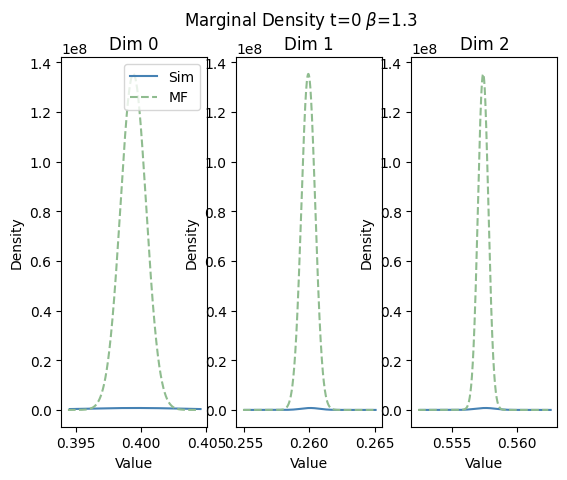

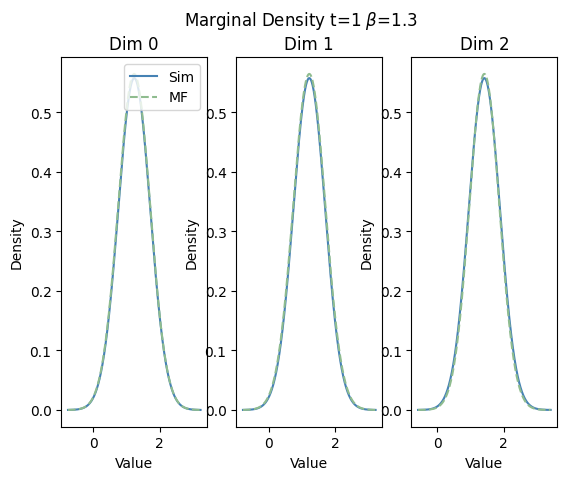

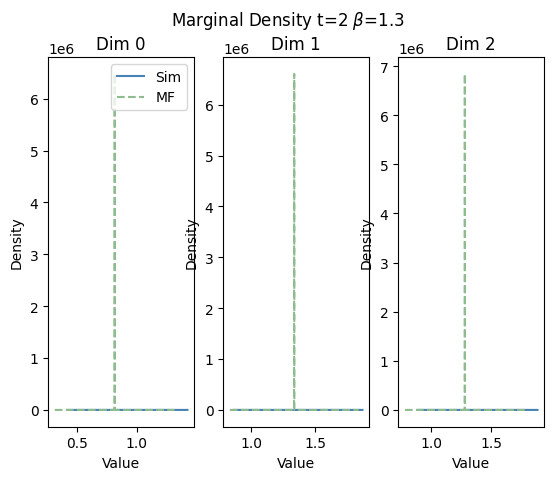

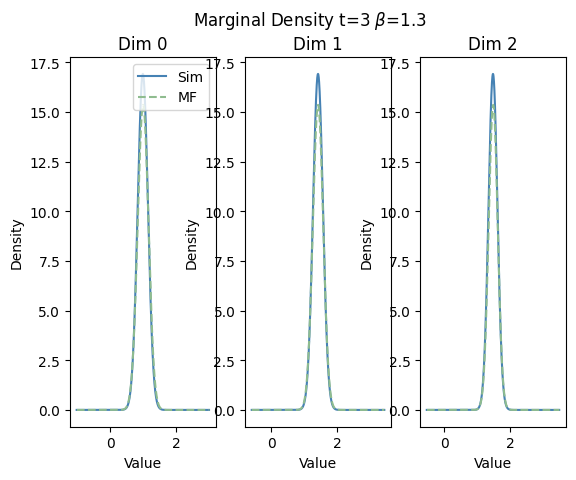

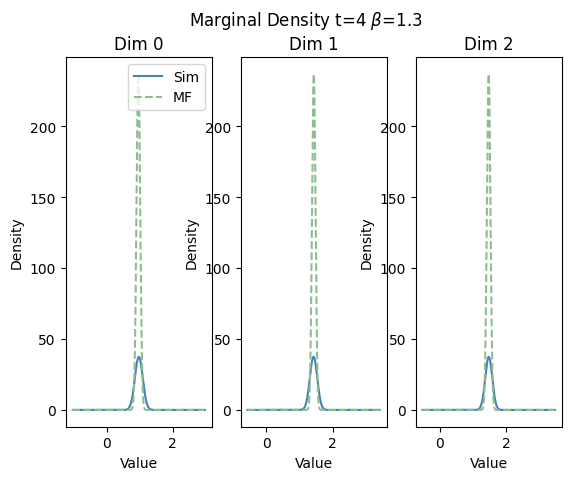

In [29]:
for t in timesteps_to_examine:
    # mean and cov for the simulated model
    q_sim_mean_t = torch.mean(tok_stats_sim[:,t,:] @ W_q.T, dim=0)
    q_sim_cov_t = torch.cov((tok_stats_sim[:,t,:] @ W_q.T).T)

    # Add small perturbation to the covariance matrix to force it being positive definite
    diag = torch.diag(torch.ones(num_patterns, num_patterns), diagonal=0) * 10**(-5)
    q_sim_cov_t += diag

    dist_sim = torch.distributions.MultivariateNormal(loc=q_sim_mean_t, covariance_matrix=q_sim_cov_t)

    # Distribution for the approximated model
    dist_mf = torch.distributions.MultivariateNormal(loc=q_mf_t[t], covariance_matrix=q_mf_cov_t[t])

    print("t", t)
    print("q sim", q_sim_mean_t)
    print("q mf", q_mf_t[t])
    print("q sim cov", q_sim_cov_t)
    print("q mf cov", q_mf_cov_t[t])

    # Grid config
    num_elems_grid = 2000
    if t == 0:
        grid_width = 0.005
    elif t == 2:
        grid_width = 0.5
    else:
        grid_width = 2
    grid = torch.linspace(-grid_width, grid_width, num_elems_grid)  # adjust range if mean is far from 0


    # Plot
    fig, axes = plt.subplots(1, 3)

    for i in range(3):
        # Simulated model
        # Prepare input: all means, but vary the selected dimension
        x_sim = q_sim_mean_t.repeat(len(grid), 1)  # shape: (grid_size, N)
        x_sim[:, i] += grid             # vary selected dimension, center on mean

        logp_sim = dist_sim.log_prob(x_sim)
        p_sim = torch.exp(logp_sim).numpy()

        # Approximated model
        # Prepare input: all means, but vary the selected dimension
        x_mf = q_mf_t[t].repeat(len(grid), 1)  # shape: (grid_size, N)
        x_mf[:, i] += grid             # vary selected dimension, center on mean

        logp_mf = dist_mf.log_prob(x_mf)
        p_mf = torch.exp(logp_mf).numpy()

        axes[i].plot(x_sim[:, i], p_sim, label=f'Sim', color='steelblue')
        axes[i].plot(x_mf[:, i], p_mf, "--", label=f'MF', color='darkseagreen')
        axes[i].set_title(f'Dim {i}')
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Density')

        if i == 0:
            axes[i].legend(loc="upper right")

    fig.suptitle(rf"Conditional Density t={timesteps_to_examine[t]} $\beta$={beta}")


In [31]:
t2 = 0
tok_stats_sim[:,t2,:] @ W_q.T

tensor([[0.3994, 0.2599, 0.5574],
        [0.3994, 0.2599, 0.5574],
        [0.3994, 0.2599, 0.5574],
        ...,
        [0.3994, 0.2599, 0.5574],
        [0.3994, 0.2599, 0.5574],
        [0.3994, 0.2599, 0.5574]])